# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.

*include contributors names here*

## 0. Setup

In [5]:
# Add any additional libraries or submodules below
##installed schrutepy for office transcripts:
##pip install schrutepy

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

##external library
from schrutepy import schrutepy

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [87]:
# Load data
d = pd.read_csv("../the_office.csv")
transcripts = schrutepy.load_schrute()

In [88]:
transcripts.head()

,index,season,episode,episode_name,director,writer,character,text,text_w_direction
0,1,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,All right Jim. Your quarterlies look very good...,All right Jim. Your quarterlies look very good...
1,2,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Oh, I told you. I couldn't close it. So...","Oh, I told you. I couldn't close it. So..."
2,3,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,So you've come to the master for guidance? Is ...,So you've come to the master for guidance? Is ...
3,4,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Jim,"Actually, you called me in here, but yeah.","Actually, you called me in here, but yeah."
4,5,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,Michael,"All right. Well, let me show you how it's done.","All right. Well, let me show you how it's done."


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int64)

In [101]:
##string cols
str_cols = (transcripts.applymap(type) == str).all(0)

##Lower names, character's and lines for easier processing
transcripts = transcripts.applymap(lambda s: s.lower() if type(s) == str else s)

##Remove spaces in character (some are incorrectly written like "jim ")
transcripts['character'] = transcripts['character'].str.replace(" ", "")
transcripts['season_ep'] = transcripts['season'].astype(str) + transcripts['episode'].astype(str)

# ##Per Episode Character lines
# transcripts.character.unique()
line_sum = transcripts.groupby(["season_ep", "character"]).size().reset_index(name = "lines") ##per character and episode lines
line_sum = line_sum.sort_values(ascending = False, by = "lines")##sort by lines


##Total line percentage per character
line_perc = line_sum.groupby("character").agg({"lines": "sum"}).sort_values(ascending = False, by = "lines")
line_perc['percentage'] = line_perc/(line_perc.sum())

##Greater than 1% line share
# main_char = line_perc.loc[line_perc['percentage'] > 0.01].index

##Top 10 line speakers (main_char)
main_char = (line_perc.nlargest(10, 'percentage')).index

##per episode lines for main characters
line_main = line_sum.loc[line_sum['character'].isin(main_char)]


Index(['michael', 'dwight', 'jim', 'pam', 'andy', 'angela', 'kevin', 'erin',
       'oscar', 'ryan'],
      dtype='object', name='character')

<AxesSubplot:xlabel='season_ep', ylabel='lines'>

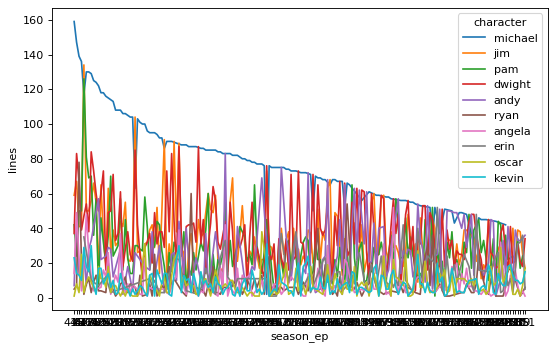

In [102]:
# transcripts.season_ep.unique()
sns.lineplot(x = "season_ep", y = "lines", hue = "character", data = line_main)


## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*